In [33]:
# %%
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [34]:
ARRIVAL = 1/3  # Fixed average inter-arrival time
SERVICE = 10.0 #avg service time per server 
SIM_TIME = 500000  # Total simulation time
SERVICE_VALUES = [i for i in range(5, 41, 2)]  # Average service times: 5.0 to 40.0 in steps of 2
TYPE1 = 1
SEED = 123 #fixed seed here 
BUFFER_SIZE = 10 #fixed buffer size - shared buffer for both servers

In [35]:
class Measure:
    def __init__(self, arr=0, dep=0, ut=0, oldT=0, delay=0):
        self.arr = arr
        self.dep = dep
        self.ut = ut
        self.oldT = oldT
        self.delay = delay
        self.bs1 = 0
        self.bs2 = 0
        self.loss = 0

In [36]:

class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

Utilization = Total busy time / Total simulation time × Number of servers

​


In [38]:
def run_simulation(num_servers, service_mean):
    global users, data, MM1, busy1, busy2
    users = 0
    data = Measure()
    MM1 = []
    time = 0
    FES = PriorityQueue()
    busy1 = False
    busy2 = False

    # NEW: Busy time tracking for actual time intervals
    start_time_1 = None
    start_time_2 = None

    def arrival(current_time):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))

        if users < BUFFER_SIZE:
            users += 1
            client = Client(TYPE1, current_time)
            MM1.append(client)

            # Single server
            if num_servers == 1:
                if not busy1:
                    s_time = random.expovariate(1 / service_mean)
                    start_time_1 = current_time
                    FES.put((current_time + s_time, "departure1"))
                    busy1 = True

            # Multi-server
            else:
                if not busy1:
                    s_time = random.expovariate(1 / service_mean)
                    start_time_1 = current_time
                    FES.put((current_time + s_time, "departure1"))
                    busy1 = True
                elif not busy2:
                    s_time = random.expovariate(1 / service_mean)
                    start_time_2 = current_time
                    FES.put((current_time + s_time, "departure2"))
                    busy2 = True
        else:
            data.loss += 1

    def departure(current_time, server_id):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2
        if len(MM1) == 0:
            if server_id == 1 and busy1:
                data.bs1 += current_time - start_time_1
                busy1 = False
            elif server_id == 2 and busy2:
                data.bs2 += current_time - start_time_2
                busy2 = False
            return

        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1

        if users > 0:
            s_time = random.expovariate(1 / service_mean)
            if server_id == 1:
                data.bs1 += current_time - start_time_1
                start_time_1 = current_time
                FES.put((current_time + s_time, "departure1"))
            else:
                data.bs2 += current_time - start_time_2
                start_time_2 = current_time
                FES.put((current_time + s_time, "departure2"))
        else:
            if server_id == 1:
                data.bs1 += current_time - start_time_1
                busy1 = False
            else:
                data.bs2 += current_time - start_time_2
                busy2 = False

    # Start simulation
    random.seed(SEED)
    FES.put((0.0, "arrival"))
    while time < SIM_TIME:
        time, event_type = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * num_servers)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0
    return avg_delay, avg_users, utilization, loss_rate


In [39]:
# %%
# Run simulations over service values
results_single = []
results_multi = []

for s in SERVICE_VALUES:
    mu = 1 / s
    res_single = run_simulation(num_servers=1, service_mean=s)
    res_multi = run_simulation(num_servers=2, service_mean=s)
    results_single.append(res_single)
    results_multi.append(res_multi)

In [40]:
# %%
# Convert to DataFrames
df_single = pd.DataFrame(results_single, columns=["Avg Delay", "Avg Users", "Utilization", "Loss Rate"])
df_single["Service Time"] = SERVICE_VALUES
df_multi = pd.DataFrame(results_multi, columns=["Avg Delay", "Avg Users", "Utilization", "Loss Rate"])
df_multi["Service Time"] = SERVICE_VALUES

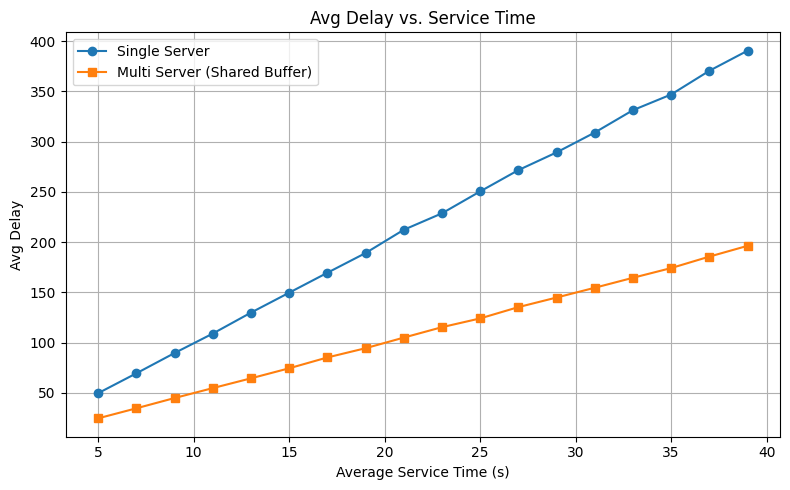

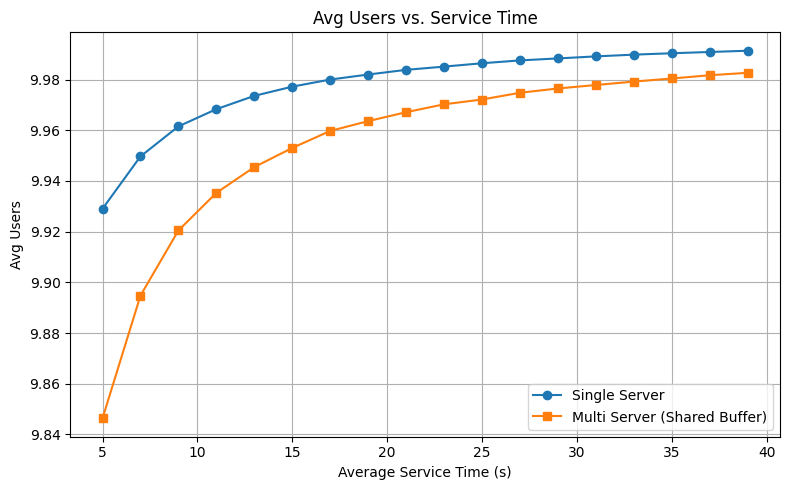

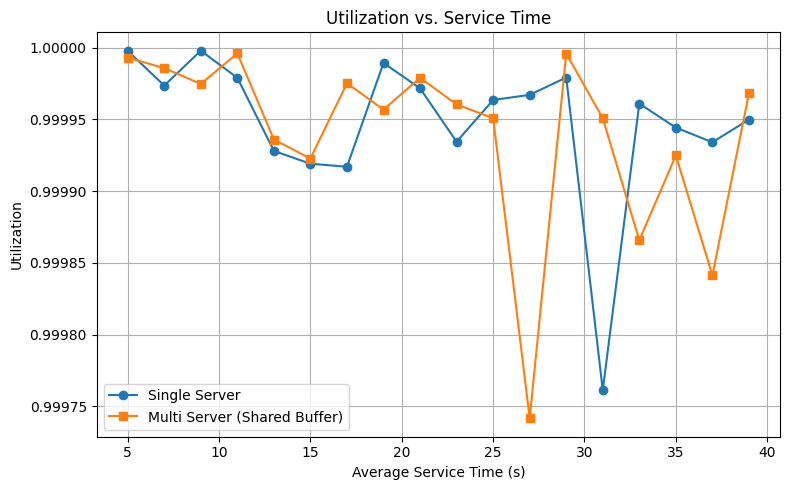

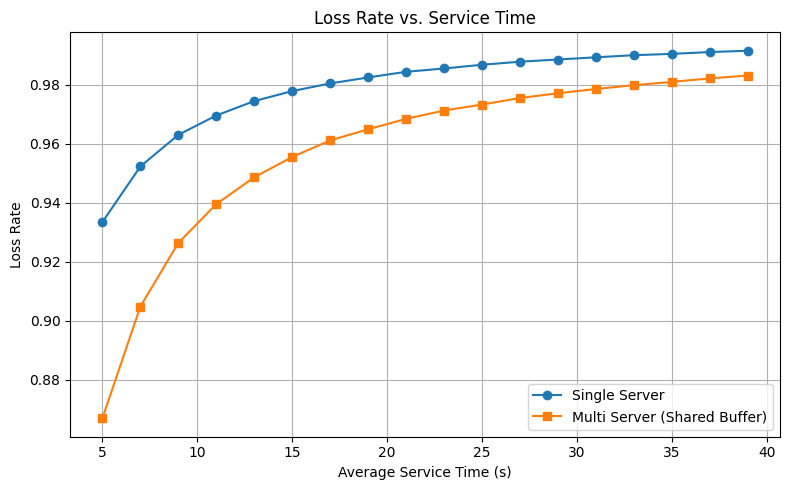

In [41]:
# %%
# Plotting: Comparison of metrics over service time
metrics = ["Avg Delay", "Avg Users", "Utilization", "Loss Rate"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(df_single["Service Time"], df_single[metric], marker='o', label='Single Server')
    plt.plot(df_multi["Service Time"], df_multi[metric], marker='s', label='Multi Server (Shared Buffer)')
    plt.xlabel("Average Service Time (s)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Service Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()